### Load modules

In [1]:
from IPython import display

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import trimesh
import trimesh.voxel.creation
import rtree

import glob
from torch.utils.data import Dataset, DataLoader
import os

In [2]:
import time

In [3]:
import scipy.ndimage as ndimage

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

In [5]:
from os import listdir
from os.path import join

In [6]:
torch.set_printoptions(profile="full")

In [7]:
import torchvision.transforms.functional as TF
from PIL import Image

### Prepare datasets

#### Load paths

In [8]:
obj_folder ='./data/objects'
img_folder ='./data/images'

#### Convert stl to voxels

In [9]:
objects = []
for file in listdir(obj_folder):
    if file.endswith(".stl"):
        m = trimesh.load_mesh(join(obj_folder,file))
        #convert to voxels
        m_vox = trimesh.voxel.creation.voxelize(m,0.3)
        objects.append(m_vox)

        
images = []
for file in listdir(img_folder):
    if file.endswith(".jpg"):
        path = os.path.join(img_folder,file)
        im=Image.open(path)
        image=TF.to_tensor(im).reshape(1,256,256)
        images.append(image)


#### Reshape tensors with padding

In [11]:
# Define size of the space (pix)
w = 32
l = 32 
h = 64 

#### definition for conversion

In [12]:
def objects_to_matrices(objs):
    vox_matrices = []
    for m in objs:
        object_matrix = torch.from_numpy(m.matrix.astype(int)) # torch.ones(m.matrix.shape)
        scene_matrix = torch.zeros((l,w,h))
            
    # center the matrices in the scene
        low = (int)(scene_matrix.size(0)//2) - (int)(object_matrix.size(0)//2)
        up = low + object_matrix.size(0)
    
        low1 = (int)(scene_matrix.size(1)//2) - (int)(object_matrix.size(1)//2)
        up1 = low1 + object_matrix.size(1)
    
        low2 = (int)(scene_matrix.size(2)//2) - (int)(object_matrix.size(2)//2)
        up2 = low2 + object_matrix.size(2)
    
    
        scene_matrix[low:up,low1:up1,low2:up2] = object_matrix
        vox_matrices.append((scene_matrix))
        
    return vox_matrices
 

In [13]:
# convert to tensors
vox_meshes = objects_to_matrices(objects)


In [14]:
encoded_objects = []
for object in vox_meshes:
    layers = object[:,:,0]
    layers = layers.reshape(256,4)
    for i in range(63):
        next = object[:,:,i+1]
        next = next.reshape(256,4)
        layers = torch.cat([layers,next],1)
        
    encoded_objects.append(layers.reshape(1,256,256))
    
len(encoded_objects)

20

In [18]:
#dataset class
class image_dataset(Dataset):
    def __init__(self, images, masks, train=True):
        self.images = images
        self.masks = masks

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]        
        #x,y = self.transform(image,mask)
        return image,mask
        
    def __len__(self):
        return len(self.images)


#### Define dataloaders

In [20]:
len_images=len(objects)
train_size =0.8
train_data = image_dataset(encoded_objects[:int(len_images*train_size)], images[:int(len_images*train_size)], train=True)
train_loader = DataLoader(train_data, batch_size = 2, shuffle = True)

test_data = image_dataset(encoded_objects[int(len_images*train_size):], images[int(len_images*train_size):], train = False)
test_loader = DataLoader(test_data, batch_size = 2, shuffle = False)

In [21]:
len(train_data)

16

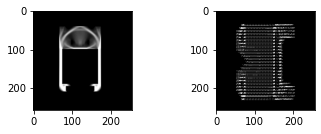

torch.Size([1, 256, 256])


In [22]:
# test plot
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(train_data[1][1][0],cmap ='gray')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(train_data[1][0][0],cmap ='gray')
plt.show()
#print(train_data[1][1])
print(train_data[0][0].shape)

### Networks

#### Set gpu device

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#### Definitions for network functions

In [24]:
def Conv_double(in_chans, out_chans):
    conv = nn.Sequential(
        nn.Conv2d(in_chans,out_chans, kernel_size =3,padding =1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_chans, out_chans, kernel_size =3,padding = 1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace=True)
    )
    return conv

def Crop_tensor(source, target):
    target_size = target.size()[2]
    source_size = source.size()[2]
    d = source_size - target_size
    if d>1:
        d = (int)(d // 2)
        return source[:,:,d:source_size-d, d:source_size-d]
    else:
        return source[:,:,d:source_size, d:source_size]

#### Image-to-image network 

In [25]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size =2, stride =2)
        
        #convolutions
        self.down_conv1 = Conv_double(1,64)
        self.down_conv2 = Conv_double(64, 128)
        self.down_conv3 = Conv_double(128, 256)
        self.down_conv4 = Conv_double(256, 512)
        self.down_conv5 = Conv_double(512, 1024)
        
        #up-convolutions
        self.conv_trans1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size=2, stride=2)
        self.up_conv1 = Conv_double(1024, 512)
        
        self.conv_trans2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size=2, stride=2)
        self.up_conv2 = Conv_double(512, 256)
        
        self.conv_trans3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=2, stride=2)
        self.up_conv3 = Conv_double(256, 128)
        
        self.conv_trans4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=2, stride=2)
        self.up_conv4 = Conv_double(128, 64)
    
        #output
        self.out = nn.Conv2d(in_channels = 64, out_channels = 1,kernel_size=1)
        
        
    def forward(self, img):
        #bs,c,h,w
        #encoder
        x1 = self.down_conv1(img) # 
        x2 = self.maxpool(x1)
        x3 = self.down_conv2(x2)   #
        x4 = self.maxpool(x3)
        x5 = self.down_conv3(x4)   #
        x6 = self.maxpool(x5)
        x7 = self.down_conv4(x6)   #
        x8 = self.maxpool(x7)
        x9 = self.down_conv5(x8) 
        
        #decoder
        x = self.conv_trans1(x9)  
        #crop tensor
        y = Crop_tensor(x7, x)        
        #conacatenate
        x = self.up_conv1(torch.cat([x,y],1))
        
        x = self.conv_trans2(x)        
        y = Crop_tensor(x5, x)        
        x = self.up_conv2(torch.cat([x,y],1))
      
        x = self.conv_trans3(x)        
        y = Crop_tensor(x3, x)
        x = self.up_conv3(torch.cat([x,y],1))

        x = self.conv_trans4(x)        
        y = Crop_tensor(x1, x)
        x = self.up_conv4(torch.cat([x,y],1))
 
        x = self.out(x)
    
        return x

### Create and train model

In [26]:
model = UNet()
model = model.to(device)
#model.apply(weights_init)
#print(model)

In [27]:
learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
# The training loop
start = time.time()
epochs = 800
total_steps = len(train_loader)

for epoch in range(epochs):
    total_train = 0
    correct_train = 0
    for i, (images, masks) in enumerate(train_loader):
        #print(masks.shape)

        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(masks)
        
        softmax = torch.nn.functional.log_softmax(outputs, dim=1)
        loss = criterion(outputs, images)
       
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += images.nelement()
        correct_train += (predicted == images).sum().item()
        train_accuracy = 100 * correct_train / total_train
         
        if (i) % 100 == 0:
            print (f"Epoch [{epoch + 1}/{epochs}], Step [{i}/{total_steps}], Loss: {loss.item():4f}, Accuracy:{train_accuracy}")
            
end = time.time()
training_time = end - start
print('training time: ', training_time)

Epoch [1/800], Step [0/8], Loss: 0.700403, Accuracy:173.3795166015625
Epoch [2/800], Step [0/8], Loss: 0.515531, Accuracy:164.32647705078125
Epoch [3/800], Step [0/8], Loss: 0.429816, Accuracy:176.5472412109375
Epoch [4/800], Step [0/8], Loss: 0.357916, Accuracy:166.63970947265625
Epoch [5/800], Step [0/8], Loss: 0.287527, Accuracy:175.9918212890625
Epoch [6/800], Step [0/8], Loss: 0.287984, Accuracy:163.19580078125
Epoch [7/800], Step [0/8], Loss: 0.262845, Accuracy:167.7703857421875
Epoch [8/800], Step [0/8], Loss: 0.247414, Accuracy:164.97802734375
Epoch [9/800], Step [0/8], Loss: 0.199997, Accuracy:175.76141357421875
Epoch [10/800], Step [0/8], Loss: 0.208946, Accuracy:173.3795166015625
Epoch [11/800], Step [0/8], Loss: 0.216749, Accuracy:165.34881591796875
Epoch [12/800], Step [0/8], Loss: 0.203950, Accuracy:171.26007080078125
Epoch [13/800], Step [0/8], Loss: 0.175835, Accuracy:172.35260009765625
Epoch [14/800], Step [0/8], Loss: 0.174622, Accuracy:172.35260009765625
Epoch [15/80

Epoch [117/800], Step [0/8], Loss: 0.061099, Accuracy:167.7703857421875
Epoch [118/800], Step [0/8], Loss: 0.056644, Accuracy:165.0543212890625
Epoch [119/800], Step [0/8], Loss: 0.057068, Accuracy:177.27508544921875
Epoch [120/800], Step [0/8], Loss: 0.065148, Accuracy:163.763427734375
Epoch [121/800], Step [0/8], Loss: 0.055983, Accuracy:167.279052734375
Epoch [122/800], Step [0/8], Loss: 0.067484, Accuracy:169.427490234375
Epoch [123/800], Step [0/8], Loss: 0.058204, Accuracy:170.86944580078125
Epoch [124/800], Step [0/8], Loss: 0.051238, Accuracy:173.3795166015625
Epoch [125/800], Step [0/8], Loss: 0.055836, Accuracy:167.279052734375
Epoch [126/800], Step [0/8], Loss: 0.059684, Accuracy:168.94989013671875
Epoch [127/800], Step [0/8], Loss: 0.050771, Accuracy:165.0543212890625
Epoch [128/800], Step [0/8], Loss: 0.060704, Accuracy:172.35260009765625
Epoch [129/800], Step [0/8], Loss: 0.047557, Accuracy:170.7916259765625
Epoch [130/800], Step [0/8], Loss: 0.056976, Accuracy:169.500732

Epoch [231/800], Step [0/8], Loss: 0.008053, Accuracy:171.52099609375
Epoch [232/800], Step [0/8], Loss: 0.009031, Accuracy:169.44122314453125
Epoch [233/800], Step [0/8], Loss: 0.005382, Accuracy:180.11627197265625
Epoch [234/800], Step [0/8], Loss: 0.007323, Accuracy:165.53192138671875
Epoch [235/800], Step [0/8], Loss: 0.011793, Accuracy:163.232421875
Epoch [236/800], Step [0/8], Loss: 0.008669, Accuracy:169.0582275390625
Epoch [237/800], Step [0/8], Loss: 0.006169, Accuracy:169.0093994140625
Epoch [238/800], Step [0/8], Loss: 0.006720, Accuracy:176.5472412109375
Epoch [239/800], Step [0/8], Loss: 0.005395, Accuracy:170.7916259765625
Epoch [240/800], Step [0/8], Loss: 0.009186, Accuracy:167.75665283203125
Epoch [241/800], Step [0/8], Loss: 0.007781, Accuracy:179.19464111328125
Epoch [242/800], Step [0/8], Loss: 0.006466, Accuracy:165.53192138671875
Epoch [243/800], Step [0/8], Loss: 0.007670, Accuracy:173.37646484375
Epoch [244/800], Step [0/8], Loss: 0.007338, Accuracy:172.95684814

Epoch [345/800], Step [0/8], Loss: 0.000128, Accuracy:167.39654541015625
Epoch [346/800], Step [0/8], Loss: 0.000121, Accuracy:170.73211669921875
Epoch [347/800], Step [0/8], Loss: 0.000133, Accuracy:176.60675048828125
Epoch [348/800], Step [0/8], Loss: 0.000131, Accuracy:169.500732421875
Epoch [349/800], Step [0/8], Loss: 0.000201, Accuracy:163.232421875
Epoch [350/800], Step [0/8], Loss: 0.000149, Accuracy:172.454833984375
Epoch [351/800], Step [0/8], Loss: 0.000126, Accuracy:171.3470458984375
Epoch [352/800], Step [0/8], Loss: 0.000146, Accuracy:168.15185546875
Epoch [353/800], Step [0/8], Loss: 0.000128, Accuracy:163.74969482421875
Epoch [354/800], Step [0/8], Loss: 0.000104, Accuracy:177.52838134765625
Epoch [355/800], Step [0/8], Loss: 0.000089, Accuracy:173.3428955078125
Epoch [356/800], Step [0/8], Loss: 0.000113, Accuracy:176.60675048828125
Epoch [357/800], Step [0/8], Loss: 0.000106, Accuracy:175.76141357421875
Epoch [358/800], Step [0/8], Loss: 0.000107, Accuracy:180.0796508

Epoch [459/800], Step [0/8], Loss: 0.000048, Accuracy:168.15185546875
Epoch [460/800], Step [0/8], Loss: 0.000040, Accuracy:171.52099609375
Epoch [461/800], Step [0/8], Loss: 0.000038, Accuracy:171.52099609375
Epoch [462/800], Step [0/8], Loss: 0.000041, Accuracy:169.500732421875
Epoch [463/800], Step [0/8], Loss: 0.000034, Accuracy:173.3795166015625
Epoch [464/800], Step [0/8], Loss: 0.000039, Accuracy:174.68719482421875
Epoch [465/800], Step [0/8], Loss: 0.000042, Accuracy:169.44122314453125
Epoch [466/800], Step [0/8], Loss: 0.000042, Accuracy:173.82965087890625
Epoch [467/800], Step [0/8], Loss: 0.000037, Accuracy:177.2979736328125
Epoch [468/800], Step [0/8], Loss: 0.000037, Accuracy:171.52099609375
Epoch [469/800], Step [0/8], Loss: 0.000035, Accuracy:170.73211669921875
Epoch [470/800], Step [0/8], Loss: 0.000035, Accuracy:167.96417236328125
Epoch [471/800], Step [0/8], Loss: 0.000044, Accuracy:170.5352783203125
Epoch [472/800], Step [0/8], Loss: 0.000039, Accuracy:172.3526000976

Epoch [573/800], Step [0/8], Loss: 0.000030, Accuracy:162.7410888671875
Epoch [574/800], Step [0/8], Loss: 0.000019, Accuracy:172.052001953125
Epoch [575/800], Step [0/8], Loss: 0.000020, Accuracy:163.67340087890625
Epoch [576/800], Step [0/8], Loss: 0.000017, Accuracy:164.97802734375
Epoch [577/800], Step [0/8], Loss: 0.000018, Accuracy:173.150634765625
Epoch [578/800], Step [0/8], Loss: 0.000018, Accuracy:167.47283935546875
Epoch [579/800], Step [0/8], Loss: 0.000018, Accuracy:167.279052734375
Epoch [580/800], Step [0/8], Loss: 0.000017, Accuracy:167.47283935546875
Epoch [581/800], Step [0/8], Loss: 0.000021, Accuracy:172.454833984375
Epoch [582/800], Step [0/8], Loss: 0.000019, Accuracy:180.07965087890625
Epoch [583/800], Step [0/8], Loss: 0.000019, Accuracy:175.74920654296875
Epoch [584/800], Step [0/8], Loss: 0.000019, Accuracy:173.18267822265625
Epoch [585/800], Step [0/8], Loss: 0.000021, Accuracy:164.85748291015625
Epoch [586/800], Step [0/8], Loss: 0.000018, Accuracy:171.71478

Epoch [687/800], Step [0/8], Loss: 0.000010, Accuracy:173.150634765625
Epoch [688/800], Step [0/8], Loss: 0.000009, Accuracy:170.73211669921875
Epoch [689/800], Step [0/8], Loss: 0.000011, Accuracy:168.0755615234375
Epoch [690/800], Step [0/8], Loss: 0.000010, Accuracy:177.52838134765625
Epoch [691/800], Step [0/8], Loss: 0.000010, Accuracy:170.86944580078125
Epoch [692/800], Step [0/8], Loss: 0.000010, Accuracy:169.48699951171875
Epoch [693/800], Step [0/8], Loss: 0.000010, Accuracy:175.79803466796875
Epoch [694/800], Step [0/8], Loss: 0.000008, Accuracy:173.3428955078125
Epoch [695/800], Step [0/8], Loss: 0.000009, Accuracy:177.3345947265625
Epoch [696/800], Step [0/8], Loss: 0.000008, Accuracy:169.25506591796875
Epoch [697/800], Step [0/8], Loss: 0.000011, Accuracy:176.67083740234375
Epoch [698/800], Step [0/8], Loss: 0.000008, Accuracy:169.25506591796875
Epoch [699/800], Step [0/8], Loss: 0.000010, Accuracy:180.07965087890625
Epoch [700/800], Step [0/8], Loss: 0.000010, Accuracy:17

training time:  3678.3920245170593


### Test and convert to 3d

In [29]:
#inverse procedure from 2d to 3d

def inverse_encoding(encoded_object):
    
    zeros = torch.zeros(encoded_object.shape)
    
    c = torch.chunk(encoded_object, 64, dim=2)
    chunks=[]
    for chunk in c:
        ch = chunk.reshape(32,32)
        chunks.append(ch)
    
    rearranged = torch.stack(chunks,2)

    c1= c[30].reshape(32,32)
    print(c1.shape)
    ones = rearranged.__ge__(0.75) 
    return ones

    

loss: tensor(1.1094, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
test accuracy: 170.892333984375
test time for 0  :  0.19946599006652832
torch.Size([32, 32])
torch.Size([32, 32])


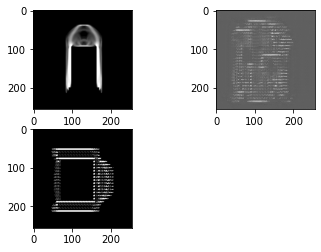

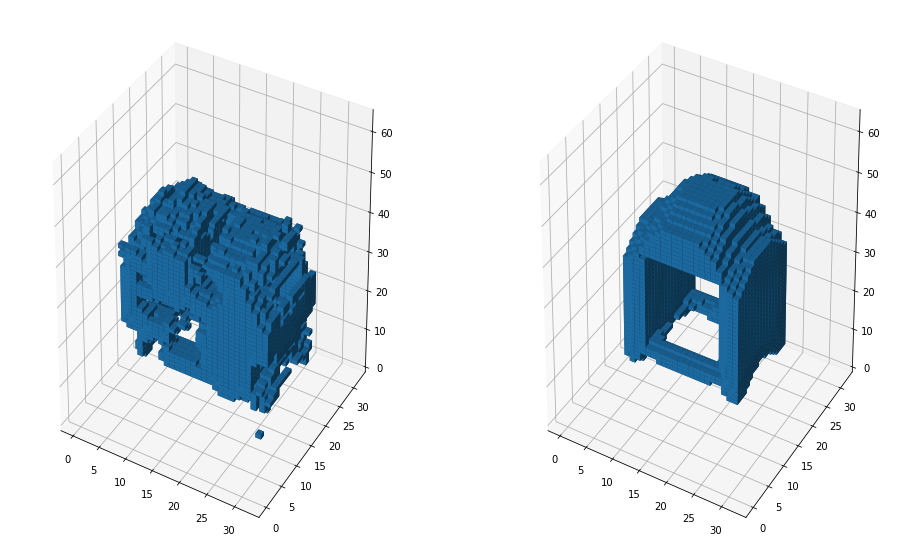

loss: tensor(1.3378, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
test accuracy: 170.892333984375
test time for 1  :  0.20145916938781738
torch.Size([32, 32])
torch.Size([32, 32])


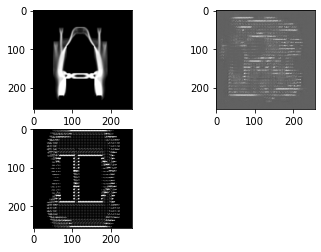

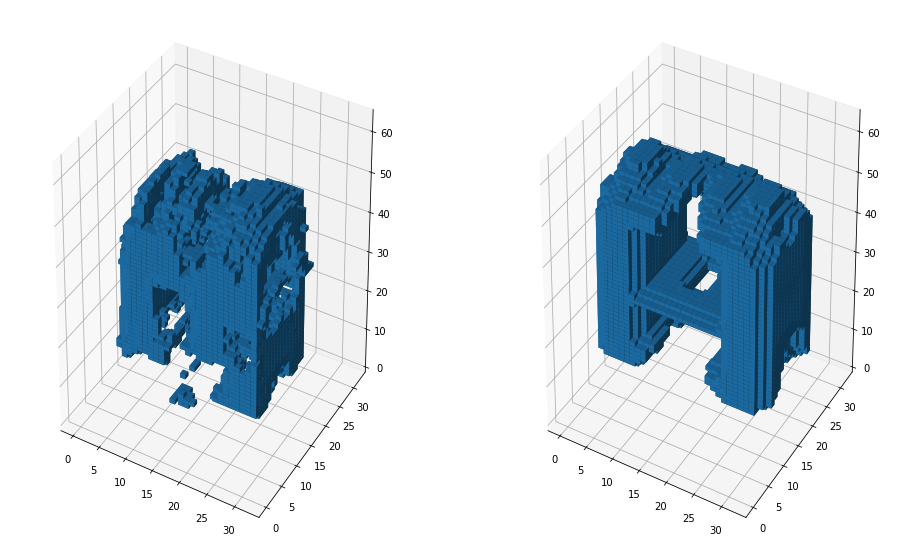

In [30]:
total_test = 0
correct_test = 0

for i, (images, masks) in enumerate(test_loader):
    start = time.time()

    masks = masks.to(device)
    images = images.to(device)
    output = model(masks)
    softmax = torch.nn.functional.log_softmax(output, dim=1)
    loss = criterion(output, images)
   
    print("loss:", loss)
    
     # accuracy
    _, predicted = torch.max(output.data, 1)
    total_test += images.nelement()
    correct_test += (predicted == masks).sum().item()
    test_accuracy = 100 * correct_train / total_train
    print("test accuracy:", test_accuracy)
    
    end = time.time()
    test_time = end - start
    print('test time for',i, ' : ', test_time)

    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(np.squeeze(masks[0].cpu().detach().numpy()),cmap = 'gray')
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(np.squeeze(output[0].cpu().detach().numpy()),cmap = 'gray')
    
    ax3 = fig.add_subplot(2,2,3)
    ax3.imshow(np.squeeze(images[0].cpu().detach().numpy()),cmap = 'gray')
    
    new_object = inverse_encoding(output[0])
    gt_object = inverse_encoding(images[0])
    
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
#    fig = plt.figure(figsize=(6,8))
#     ax1 = fig.gca(projection='3d')
    ax1.voxels(new_object)
    
#    ax2 = fig.gca(projection='3d')
    ax2.voxels(gt_object)

    plt.show()

#### Convert from voxels to mesh

In [33]:
verts, faces, normals, values = skimage.measure.marching_cubes(torch.Tensor.cpu(new_object).detach().numpy(),0)

In [32]:
import skimage
import skimage.measure

In [ ]:
finMesh = trimesh.Trimesh(verts,faces)
finMesh = trimesh.smoothing.filter_humphrey(finMesh, alpha=0.1, beta=0.3, iterations=15, laplacian_operator=None)
finMesh.export('dMesh_s.obj')